In [ ]:
# For running in colab  
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 


# Implementation of the first Bayesian Network
1. The Bayesian network contains infromation regarding the main risks factor of heart disease.
 
2. CPT's are obtained using statistics from Istat and american heart association.

3. The project aims to analyse how much individual behaviours could influence the development of an heart disease.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx # to draw the BN's

# Network structure

medical_bn = BayesianNetwork([
    ('Moderate exercise', 'Obesity'), 
    ('Diet', 'Obesity'),
    ('Obesity', 'Heart disease'),
    ('Age', 'Heart disease'),
    ('Smoke', 'Heart disease'),
    ('Family history', 'Heart disease')
    ])

PA_cpd = TabularCPD('Moderate exercise', 2, [[.259], [.741]])
Diet_cpd = TabularCPD('Diet', 2, [[.550], [.450]])
Obesity_cpd = TabularCPD('Obesity', 2, [[.4, .90, .95, .99],[.6, .10, .05, .01]], 
                     evidence = ['Moderate exercise', 'Diet'], evidence_card = [2,2])
Age_cpd = TabularCPD('Age', 2, [[.45], [.55]]) #Distribution of people of age 35-54 compared to 55-74
Genetic_factors_cpd = TabularCPD('Family history', 2, [[.774], [.226]])

Smoke_cpd = TabularCPD('Smoke', 2, [[.81], [.19]])

# The heart disease cpd can be computed using a noisy-OR structure, in fact
# the failure probabilities for each cause are independent.
# So, given the single failure probabilities, obtained by statistics the cpd can be 
# easily completed
# P[!heart disease | smoke=1] = .65
# P[!heart disease | obesity=1] = .66
# P[!heart disease | genetic factors=1] = .45
# P[!heart disease | age=1 (35-54)] = .9877    P[!heart disease | age=0 (55-74)] = 0.9527

failures = [.9877, .9527, .628, .619, .65, .63, .42, .40, .42, .44, .28, .29, .28, .29, .18, .19]
notfailures = [1- failure for failure in failures] 
Heart_disease_cpd = TabularCPD('Heart disease', 2, [failures, notfailures], 
                     evidence = ['Family history', 'Smoke', 'Obesity', 'Age'], 
                     evidence_card = [2,2,2,2]) 
medical_bn.add_cpds(PA_cpd, Diet_cpd, Obesity_cpd, Age_cpd, Genetic_factors_cpd, Smoke_cpd, Heart_disease_cpd)

In [ ]:
medical_bn.check_model()

True

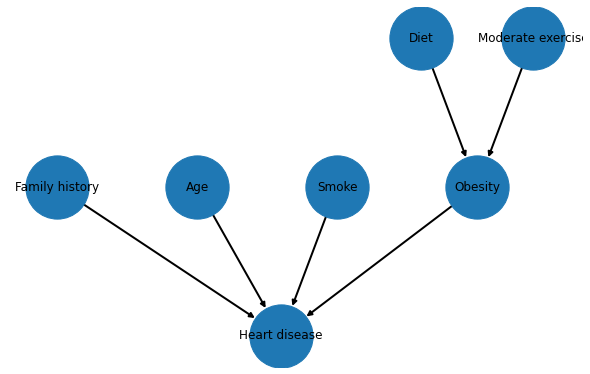

In [ ]:
# Lets plot the network
plt.figure(figsize = (8, 5))
pos = {
    'Moderate exercise' : (4.2, 5),
    'Diet': (3.8, 5),
    'Obesity': (4, 4.5),
    'Smoke': (3.5, 4.5),
    'Age': (3, 4.5),
    'Family history': (2.5, 4.5),
    'Heart disease': (3.3, 4)
}
nx.draw(medical_bn, pos=pos, with_labels=True, node_size=4000, width=2, arrowsize=10)

### Structural observations
Even if this network is very simple and consequently far away to a good approximation of the problem computing the CPD's in a precise way is really hard.

Indeed, finding priors is not so difficult using statistic institutes (like ISTAT), but even simple conditional probabilities aren't considered in this kind of report, especially when the causes grows in number.

I must say that when the complexity grows, a manual computation become practically impossible, even with a wide knowledge of the problem. 

Consequently, I made two main considereation : 
1. Bayesian network are a really powerful tool for analysing a problem, because are pretty simple to understand, and they offer a complete analysis of a problem.

2. Obtaining reliable networks with statistics is a taugh job, so for complex problems the usage of datasets to obtain at least the parameters is extremely important.

In [ ]:
inference = VariableElimination(medical_bn)

In [ ]:
print('P[Heart disease]')
heart_prob = inference.query(['Heart disease'])
print(heart_prob)
heart_disease_prob = heart_prob.values[1]

P[Heart disease]
+------------------+----------------------+
| Heart disease    |   phi(Heart disease) |
+==================+======================+
| Heart disease(0) |               0.7583 |
+------------------+----------------------+
| Heart disease(1) |               0.2417 |
+------------------+----------------------+


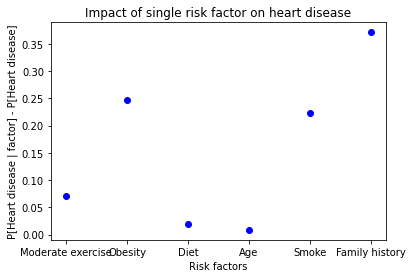

In [ ]:
# 1) Lets analyse which one of the direct and not dicrect causes more likely influence heart disease

# I compute the probability of Heart disease for all ancestors of heart disease
ancestral_graph = medical_bn.get_ancestral_graph('Heart disease')

evidence_list = [variable for variable in ancestral_graph.nodes if variable != 'Heart disease']
evd_dict1 = {}
for el in evidence_list:
    prob = inference.query(['Heart disease'], evidence={el : 1}).values[1]
    evd_dict1[el] = heart_disease_prob < prob
Queries_values = [inference.query(['Heart disease'], evidence={key : evd_dict1[key]}).values[1] - heart_disease_prob for key in evd_dict1]




plt.plot(range(len(Queries_values)), Queries_values, 'bo')

plt.xticks(range(len(Queries_values)), evidence_list)
plt.title('Impact of single risk factor on heart disease')
plt.xlabel('Risk factors')
plt.ylabel('P[Heart disease | factor] - P[Heart disease]')
plt.show()

In [ ]:
### Probability of heart disease when bad health factors are evidence
bad_health_dict = {'Smoke' : 1, 'Diet' : 1, 'Moderate exercise' : 0}

# It's not necessary to include in evidence Diet and Phisical activity, because they are clearly 
# independent to heart disease given Obesity

query_bh = inference.query(['Heart disease'], evidence = bad_health_dict)
print('P[Heart Disease | bad_health] = {}'.format(query_bh.values[1]))

# According to this BN the impact of bad health on heart disease 
good_health_dict = {parent : not bad_health_dict[parent] for parent in bad_health_dict}

query_gh = inference.query(['Heart disease'], evidence = good_health_dict)
print('P[Heart Disease | good_health] = {}'.format(query_gh.values[1].round(3)))


print('Difference between probabilities: {}'.format(query_bh.values[1] - query_gh.values[1]))


P[Heart Disease | bad_health] = 0.46095299999999995
P[Heart Disease | good_health] = 0.168
Difference between probabilities: 0.29292816999999993


## **Implementation of the second Bayesian Network.**
*Valorta M. and Gosh J. 
**Building of heart disease** 1999.*


In [ ]:
# 1) Structure construction
medical_bn2 = BayesianNetwork(
    [('Diet', 'Obesity'),
     ('Diet', 'Serum Trig'),
     ('Diet', 'Chol_HDL_ratio'),
     ('Moderate exercise', 'Obesity'),
     ('Moderate exercise', 'High BP'),
     ('Medicine taken', 'High BP'),
     ('Smoke', 'High BP'),
     ('Obesity', 'High BP'),
     ('Diet', 'Serum LDL'),
     ('Diet', 'Serum selenium'),
     ('Moderate exercise', 'Atherosclerosis'),
     ('Serum LDL', 'Atherosclerosis'),
     ('Serum Trig', 'Atherosclerosis'),
     ('Chol_HDL_ratio', 'Atherosclerosis'),
     ('High BP', 'Heart disease'),
     ('Atherosclerosis', 'Heart disease'),
     ('Family history', 'Heart disease'),
     ('Serum selenium', 'Heart disease'),
     ('Adverse medicine', 'Heart disease'),
     ('Heart disease', 'ECG'),
     ('Heart disease', 'Angina pectoris'),
     ('Heart disease', 'Miocardial infraction'),
     ('Heart disease', 'Rapid heartbeats')
     ]
)

In [ ]:
print(medical_bn2.number_of_nodes(), medical_bn2.number_of_edges())

18 23


In [ ]:
# CPD's building

diet_cpd = TabularCPD('Diet', 2, [[.40], [.60]])
mod_exc_cpd = TabularCPD('Moderate exercise', 2, [[.50], [.50]])


serum_trig_cpd = TabularCPD('Serum Trig', 2, [[.30, .80], [.70, .20]], evidence=['Diet'], evidence_card=[2])
sldl_cpd = TabularCPD('Serum LDL', 2, [[.75, .25], [.25, .75]], evidence=['Diet'], evidence_card=[2])
chol_cpd = TabularCPD('Chol_HDL_ratio', 2, [[.75, .25], [.25, .75]], evidence=['Diet'], evidence_card=[2])
ssm_cpd = TabularCPD('Serum selenium', 2 ,[[.70, .30], [.30, .70]], evidence=['Diet'], evidence_card=[2])

ecg_cpd = TabularCPD('ECG', 2, [[.95, .05], [.05, .95]], 
                     evidence=['Heart disease'], evidence_card=[2])

angp_cpd = TabularCPD('Angina pectoris', 2, [[.60, .15], [.40, .85]],
                      evidence = ['Heart disease'], evidence_card=[2])

miocar_cpd = TabularCPD('Miocardial infraction', 2, [[.95, .10], [.05, .90]], 
                        evidence = ['Heart disease'], evidence_card=[2])

rhb_cpd = TabularCPD('Rapid heartbeats', 2, [[.70, .01], [.30, .99]],
                     evidence = ['Heart disease'], evidence_card=[2])

ath_cpd = TabularCPD('Atherosclerosis', 2, 
                     [[.39, .43, .43, .48, .16, .17, .17, .19,
                       .65, .72, .72, .80, .26, .29, .29, .32],
                      [.61, .57, .57, .52, .84, .83, .83, .81, 
                       .35, .28, .28, .20 ,.74, .71, .71, .68]],
                     evidence=['Serum LDL', 'Serum Trig', 'Moderate exercise', 'Chol_HDL_ratio'],
                     evidence_card=[2,2,2,2])

smoke_alc_cpd = TabularCPD('Smoke', 2, [[.80], [.20]])
med_tak_cpd = TabularCPD('Medicine taken', 2, [[.50], [.50]])

obes_cpd = TabularCPD('Obesity', 2, [[.40, .90, .90, .95],[.60, .10, .10, .05]], 
                      evidence=['Moderate exercise', 'Diet'],
                      evidence_card=[2,2])

hbp_cpd = TabularCPD('High BP', 2, 
                     [[.30, .24, .48, .42, .13, .08, .21, .15, .75, .69, .93, .87, .48, .42, .66, .60],  
                      [.70, .76, .52, .58, .87, .92, .79, .85, .25, .31, .07, .13, .52, .58, .34, .40]],
                     evidence=['Medicine taken', 'Smoke', 'Moderate exercise', 'Obesity'],
                     evidence_card = [2,2,2,2])

fam_his_cpd = TabularCPD('Family history', 2, [[.85], [.15]])
adv_med_cpd = TabularCPD('Adverse medicine', 2, [[.20], [.80]])

heart_disease_cpd = TabularCPD('Heart disease', 2,
                               [[.72, .65, .58, .52, .29, .26, .23, .21, .90, .81, .72, 
                                 .65, .36, .32, .29, .26, .22, .20, .18, .16, .09, .08, 
                                 .07, .06, .27, .24, .22, .20, .11, .10, .09, .09],
                                
                                [.28, .35, .42, .48, .71, .74, .77, .79, .10, .19, .28, 
                                 .35, .64, .68, .71, .74, .78, .80, .82, .84, .91, .92, 
                                 .93, .94, .73, .76, .78, .80, .89, .90, .91, .91,]],
                               evidence=['Atherosclerosis', 'Serum selenium',
                                         'High BP', 'Family history', 'Adverse medicine'],
                               evidence_card=[2,2,2,2,2])


In [ ]:
medical_bn2.add_cpds(diet_cpd, mod_exc_cpd,
                     serum_trig_cpd, sldl_cpd,
                     chol_cpd, ssm_cpd, ecg_cpd,
                     angp_cpd, miocar_cpd, rhb_cpd,
                     ath_cpd, smoke_alc_cpd, med_tak_cpd,
                     obes_cpd, hbp_cpd, fam_his_cpd, 
                     adv_med_cpd, heart_disease_cpd
                     )

In [ ]:
medical_bn2.check_model()

True

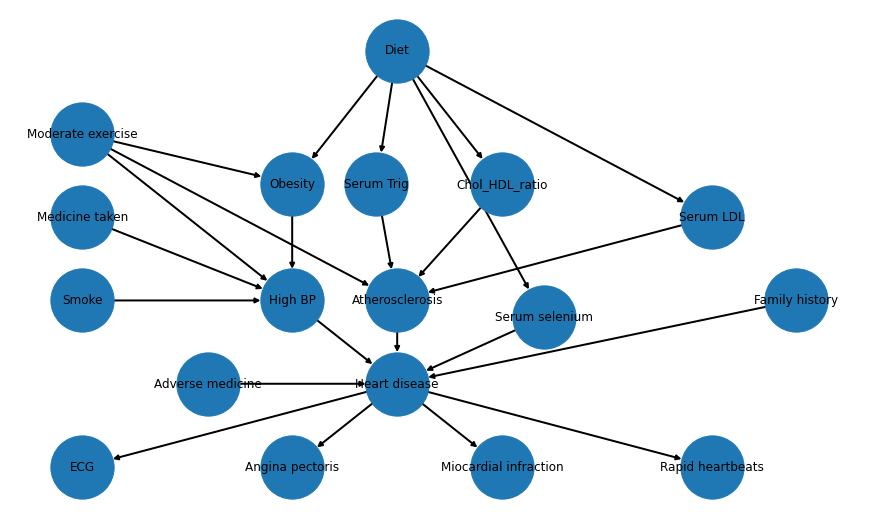

In [ ]:
# Lets plot also this network
plt.figure(figsize=(12, 7))
pos = {
    'ECG': (1, 1),
    'Angina pectoris': (1.5 , 1),
    'Miocardial infraction': (2, 1),
    'Rapid heartbeats': (2.5, 1),
    'Adverse medicine': (1.3, 1.5),
    'Heart disease': (1.75, 1.5),
    'Serum selenium': (2.1, 1.9),
    'Smoke': (1, 2),
    'High BP': (1.5, 2),
    'Atherosclerosis': (1.75, 2),
    'Family history': (2.7, 2),
    'Serum LDL': (2.5, 2.5),
    'Medicine taken':(1, 2.5),
    'Obesity': (1.5, 2.7),
    'Serum Trig': (1.7, 2.7),
    'Chol_HDL_ratio': (2, 2.7),
    'Diet': (1.75, 3.5),
    'Moderate exercise':(1, 3)
}
nx.draw(medical_bn2,pos=pos, with_labels=True, node_size=4000, width=2, arrowsize=10)

# **Inference in the second network**
This BN is more complex than the one implemented before, if particular this network contains intermediate values, which represent clinical conditions (like High blood pressure or Atherosclerosis). So there isn't a direct connection beteween behaviours and heart disease in the graph 

The probability of heart disease without evidence in this BN is really higher than the one in the first netwrok. This fact cuold be caused by the differences of prior statistics and by the different structure of the two netwroks.

Nevertheless, it's possible to compare queries obtained by both graphs.

In [ ]:
inference2 = VariableElimination(medical_bn2)
# Lets compute the probability of heart disease without evidence
print("P['Heart disease']")
query = inference2.query(['Heart disease'])
print(query)


P['Heart disease']
+------------------+----------------------+
| Heart disease    |   phi(Heart disease) |
+==================+======================+
| Heart disease(0) |               0.3397 |
+------------------+----------------------+
| Heart disease(1) |               0.6603 |
+------------------+----------------------+


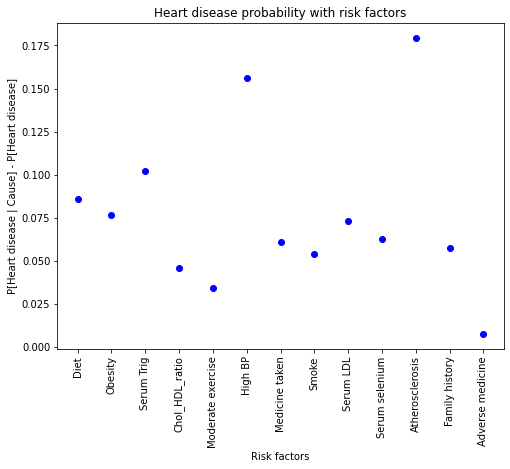

In [ ]:
p_h_true2 = query.values[1]  # Prob of (CVD = True) without evidence
anc_tree = medical_bn2.get_ancestral_graph('Heart disease')

evd_list = [node for node in anc_tree.nodes if node != 'Heart disease']

evd_dict = {}
for el in evd_list:
    prob = inference2.query(['Heart disease'], evidence={el : 1}).values[1]
    evd_dict[el] = p_h_true2 < prob
Queries_values = [inference2.query(['Heart disease'], evidence={key : evd_dict[key]}).values[1] - p_h_true2 for key in evd_dict]



import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8, 6))
plt.plot(range(len(Queries_values)), Queries_values, 'bo')
plt.xticks(range(len(evd_list)), evd_list, rotation = 90)
plt.title('Heart disease probability with risk factors')
plt.xlabel('Risk factors')
plt.ylabel('P[Heart disease | Cause] - P[Heart disease]')
plt.show()

## Comparison
It's now possible to understand if even in this implementation the impact of non clinical events ( like diet, phisical activity) is so high.

In [ ]:
# Lets isolate the behavioural nodes
bad_behaviour_dict = {'Diet': 0, 'Smoke' : 1, 'Moderate exercise': 1}
good_behaviour_dict = {key: not bad_behaviour_dict[key] for key in bad_behaviour_dict}

# Compute P[CVD | unhealthy behaviour]
prob_bad = inference2.query(['Heart disease'], evidence=bad_behaviour_dict).values[1] 
print('Heart disease probability with unhelathy lifestyle : {}'.format(prob_bad))

# Compute P[CVD | healthy behaviour]
prob_good = inference2.query(['Heart disease'], evidence=good_behaviour_dict).values[1]
print('Heart disease probability with helathy lifestyle : {}'.format(prob_good))
print('Increment: {}'.format(prob_bad - prob_good))

Heart disease probability with unhelathy lifestyle : 0.7665870453399999
Heart disease probability with helathy lifestyle : 0.629084585375
Increment: 0.13750245996499988
